In [51]:
import os
import pandas as pd
from html_similarity import style_similarity, structural_similarity, similarity
from bs4 import BeautifulSoup, Doctype
from bs4.element import Comment
from collections import Counter
from scipy.spatial import distance
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import string
import spacy
from nltk.metrics import edit_distance
from nltk.metrics import edit_distance
from nltk.metrics import interval_distance
from nltk import jaccard_distance
import textdistance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
import datetime
import fbprophet
import gc
import math
import numpy as np
from fastparquet import ParquetFile

In [11]:
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

def text_from_html(htmlPage):
    soup = BeautifulSoup(htmlPage, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)
    return u" ".join(t.strip() for t in visible_texts)

def split(word): 
    return [char for char in word]

def filter_text(text):
    stop_words = set(stopwords.words('english'))
    stop_words.update(split(string.punctuation))
    nlp = spacy.load('en_core_web_sm')
    spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
    stop_words.update(spacy_stopwords)
    #stop_words.update(["\\t","\\n","\\r"])
    
    text = text.replace("\\n", "")
    text = text.replace("\\r", "")
    text = text.replace("\\t", "")    
    
    word_tokens_text = word_tokenize(text)

    filtered_text = [w for w in word_tokens_text if not w in stop_words]

    filtered_text = TreebankWordDetokenizer().detokenize(filtered_text)
    
    return filtered_text

In [12]:
archiveData = pd.read_pickle("./archiveData.pkl")

In [23]:
def classifyProphet(archiveData):
    
    basePayload = archiveData.iloc[0]['payload']
    basePayloadText = text_from_html(basePayload)
    basePayloadFilteredText = filter_text(basePayloadText)
    baseTimestamp = datetime.datetime.strptime(archiveData.iloc[0]['timestamp'], '%Y%m%d%H%M%S')
    lastSavedDataIndex = 0
    timeElapsed = 0
    dataset = []

    for i in range(1, len(archiveData)):
        
        print("Proceesing " + str(i))
        
        hasContentChanged = 0

        overallSimilarity = similarity(basePayload, archiveData.iloc[i]['payload'])
        styleSimilarity = style_similarity(basePayload, archiveData.iloc[i]['payload'])
        structuralSimilarity = structural_similarity(basePayload, archiveData.iloc[i]['payload'])

        timestamp = datetime.datetime.strptime(archiveData.iloc[i]['timestamp'], '%Y%m%d%H%M%S')

        archiveText = text_from_html(archiveData.iloc[i]['payload'])
        filteredArchiveText = filter_text(archiveText)

        cosineSimilarity = textdistance.cosine.normalized_similarity(basePayloadFilteredText , filteredArchiveText)
        jaccardSimilarity = textdistance.jaccard.normalized_similarity(basePayloadFilteredText , filteredArchiveText)
        #editDistanceSimilarity = textdistance.levenshtein.normalized_similarity(basePayloadFilteredText , filteredArchiveText)
        sorensenDiceSimilarity = textdistance.sorensen_dice.normalized_similarity(basePayloadFilteredText , filteredArchiveText)
        
        #print(overallSimilarity, cosineSimilarity, jaccardSimilarity, sorensenDiceSimilarity)
        if(overallSimilarity < 0.98 or cosineSimilarity < 1):
            hasContentChanged = 1
            lastSavedDataIndex = i
            basePayload = archiveData.iloc[i]['payload']
            basePayloadText = archiveText
            basePayloadFilteredText = filteredArchiveText
            baseTimestamp = datetime.datetime.strptime(archiveData.iloc[i]['timestamp'], '%Y%m%d%H%M%S')

        data = [timestamp, hasContentChanged]
        dataset.append(data)

    df = pd.DataFrame(dataset, columns = ['ds', 'y'])
    
    m = fbprophet.Prophet()
    m.fit(df)
    print(df)
    future = m.make_future_dataframe(periods=1, freq="5H", include_history = False)
    forecast = m.predict(future)
    
    allfuture = m.make_future_dataframe(periods=72, freq="5H", include_history = True)
    allforecast = m.predict(allfuture)
    
    print(forecast)
    
    fig1 = m.plot(allforecast)
    fig2 = m.plot_components(allforecast)
    
    return forecast

Proceesing 1
Proceesing 2
Proceesing 3
Proceesing 4
Proceesing 5
Proceesing 6
Proceesing 7
Proceesing 8
Proceesing 9
Proceesing 10
Proceesing 11
Proceesing 12
Proceesing 13
Proceesing 14
Proceesing 15
Proceesing 16
Proceesing 17
Proceesing 18
Proceesing 19
Proceesing 20
Proceesing 21
Proceesing 22
Proceesing 23
Proceesing 24
Proceesing 25
Proceesing 26
Proceesing 27
Proceesing 28
Proceesing 29
Proceesing 30
Proceesing 31
Proceesing 32
Proceesing 33
Proceesing 34
Proceesing 35
Proceesing 36
Proceesing 37
Proceesing 38
Proceesing 39
Proceesing 40
Proceesing 41
Proceesing 42
Proceesing 43
Proceesing 44
Proceesing 45
Proceesing 46
Proceesing 47
Proceesing 48
Proceesing 49
Proceesing 50
Proceesing 51
Proceesing 52
Proceesing 53
Proceesing 54
Proceesing 55
Proceesing 56
Proceesing 57
Proceesing 58
Proceesing 59
Proceesing 60
Proceesing 61
Proceesing 62
Proceesing 63
Proceesing 64
Proceesing 65
Proceesing 66
Proceesing 67
Proceesing 68
Proceesing 69
Proceesing 70
Proceesing 71
Proceesing 72
P

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


                     ds  y
0   2019-11-06 17:10:18  0
1   2019-11-06 19:10:18  0
2   2019-11-06 20:10:18  0
3   2019-11-07 00:10:18  0
4   2019-11-07 01:10:18  0
..                  ... ..
171 2019-11-19 06:10:18  0
172 2019-11-19 07:10:18  0
173 2019-11-19 08:10:18  0
174 2019-11-19 09:10:18  0
175 2019-11-19 11:10:18  0

[176 rows x 2 columns]
                   ds     trend  yhat_lower  yhat_upper  trend_lower  \
0 2019-11-19 16:10:18  0.031191   -0.024171    0.247586     0.031191   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0     0.031191         0.07207               0.07207               0.07207   

     daily  daily_lower  daily_upper  multiplicative_terms  \
0  0.07207      0.07207      0.07207                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.103261  


ds     trend  yhat_lower  yhat_upper  trend_lower  \
0 2019-11-19 16:10:18  0.031191   -0.024171    0.247586     0.031191   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0     0.031191         0.07207               0.07207               0.07207   

     daily  daily_lower  daily_upper  multiplicative_terms  \
0  0.07207      0.07207      0.07207                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.103261

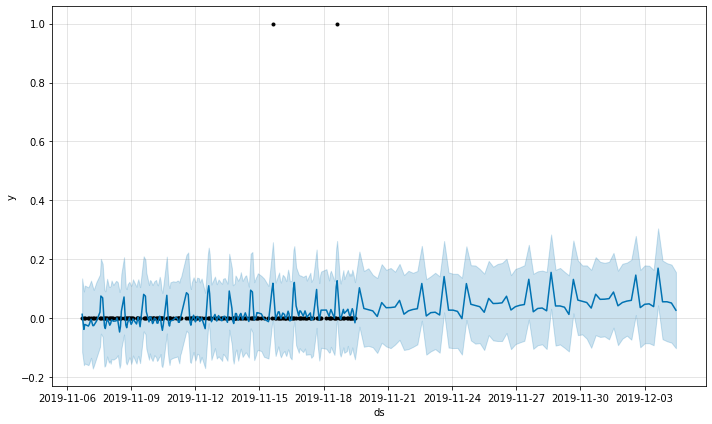

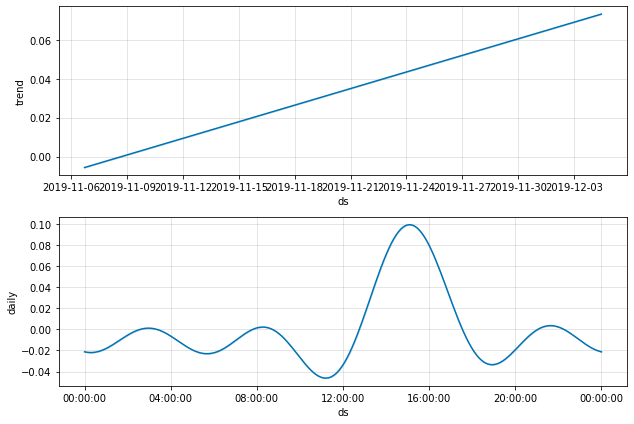

In [24]:
classifyProphet(archiveData)

In [54]:
def classiyWindowSVM(archiveData):
   
    basePayload = archiveData.iloc[0]['payload']
    basePayloadText = text_from_html(basePayload)
    basePayloadFilteredText = filter_text(basePayloadText)
    baseTimestamp = datetime.datetime.strptime(archiveData.iloc[0]['timestamp'], '%Y%m%d%H%M%S')
    lastSavedDataIndex = 0
    timeElapsed = 0
    dataset = []

    print(str(len(archiveData)) + " datapoints found")

    for i in range(1, len(archiveData)):
        if(i % 10 is 0):
            print(str(i) + " Records processed")

        hasContentChanged = False

        overallSimilarity = similarity(basePayload, archiveData.iloc[i]['payload'])
        styleSimilarity = style_similarity(basePayload, archiveData.iloc[i]['payload'])
        structuralSimilarity = structural_similarity(basePayload, archiveData.iloc[i]['payload'])
       
        timestamp = datetime.datetime.strptime(archiveData.iloc[i]['timestamp'], '%Y%m%d%H%M%S')
        baseTimestampDiff = ((timestamp - baseTimestamp).total_seconds())/3600.0
        archiveText = text_from_html(archiveData.iloc[i]['payload'])
        filteredArchiveText = filter_text(archiveText)

        cosineSimilarity = textdistance.cosine.normalized_similarity(basePayloadFilteredText , filteredArchiveText)
        jaccardSimilarity = textdistance.jaccard.normalized_similarity(basePayloadFilteredText , filteredArchiveText)
        #editDistanceSimilarity = textdistance.levenshtein.normalized_similarity(basePayloadFilteredText , filteredArchiveText)
        sorensenDiceSimilarity = textdistance.sorensen_dice.normalized_similarity(basePayloadFilteredText , filteredArchiveText)

        if(overallSimilarity < 0.98 or cosineSimilarity < 1):
            hasContentChanged = True
            lastSavedDataIndex = i
            basePayload = archiveData.iloc[i]['payload']
            basePayloadText = archiveText
            basePayloadFilteredText = filteredArchiveText
            baseTimestamp = datetime.datetime.strptime(archiveData.iloc[i]['timestamp'], '%Y%m%d%H%M%S')


        data = [baseTimestampDiff, overallSimilarity, styleSimilarity, structuralSimilarity, cosineSimilarity, jaccardSimilarity, sorensenDiceSimilarity, hasContentChanged]
        dataset.append(data)

   
   
    df = pd.DataFrame(dataset, columns = ['timeDiff', 'similarity', 'styleSimilarity', 'structureSimilarity',                                           'cosine', 'jaccard', 'sorensen', 'changed'])
    print("Dataframe created")
   
   
    X = []
    y = []
    
    windowSize = 10
   
    for i in range(len(df.index) - windowSize - 1):
        bound = min(i + windowSize + 1, len(archiveData))
        window = df.iloc[i:bound-1, 0].values
        windowLabel = df.iloc[bound, 7]
        X.append(window)
        y.append(windowLabel)
   
    trainEx = math.floor(len(X)*0.8)
   
    X_train = X[0:trainEx]
    y_train = y[0:trainEx]
   
    X_test = X[trainEx:]
    y_test = y[trainEx:]
   
    print("Starting SVM Classification")
    
    print(X_train, y_train)
   
    regressor = svm.SVC()
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    
    print(y_pred)
   
    return np.mean(y_test == y_pred)

In [55]:
print(classiyWindowSVM(archiveData))

177 datapoints found
10 Records processed
20 Records processed
30 Records processed
40 Records processed
50 Records processed
60 Records processed
70 Records processed
80 Records processed
90 Records processed
100 Records processed
110 Records processed
120 Records processed
130 Records processed
140 Records processed
150 Records processed
160 Records processed
170 Records processed
Dataframe created
Starting SVM Classification
[array([ 1.,  3.,  4.,  8.,  9., 11., 13., 14., 17., 21.]), array([ 3.,  4.,  8.,  9., 11., 13., 14., 17., 21., 22.]), array([ 4.,  8.,  9., 11., 13., 14., 17., 21., 22., 24.]), array([ 8.,  9., 11., 13., 14., 17., 21., 22., 24., 26.]), array([ 9., 11., 13., 14., 17., 21., 22., 24., 26., 27.]), array([11., 13., 14., 17., 21., 22., 24., 26., 27., 28.]), array([13., 14., 17., 21., 22., 24., 26., 27., 28., 29.]), array([14., 17., 21., 22., 24., 26., 27., 28., 29., 31.]), array([17., 21., 22., 24., 26., 27., 28., 29., 31., 32.]), array([21., 22., 24., 26., 27., 28.,

/home/naman/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
